In [12]:
# imports and loadings
import os
import sys
sys.path.insert(0, '../functions/')
import mRNA_ratios as mr
import create_data_for_single_gene as cdg

import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# settings
case = 'purR'
small_or_full = 'full'

# setting up genes, promoter, and inhibitor
if case == 'argR':
    promoter = None
    inhibitor = 'b3237'
    genes = ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254']
    if small_or_full == 'small':
        genes = genes[0:3]
elif case == 'fadR':
    promoter = 'b1187'
    inhibitor = None
    genes = ['b3255', 'b1288', 'b0185', 'b3256', 'b2316']
    if small_or_full == 'small':
        genes = genes[0:3]
elif case == 'purR':
    promoter = None
    inhibitor = 'b1658'
    genes = ['b1849', 'b2499', 'b0523', 'b2557', 'b0522', 'b4006', 'b2476', 'b4005', 'b2313', 'b2312', 'b2500', 'b1131']
    if small_or_full == 'small':
        genes = genes[0:3]
        
# below are the default flags used if nothing is pre-set
# set flags by editing the "saved_flags.csv" in the ../data folder
flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
t_half_life_deg = 300
stable_flags = { # these do not change gene by gene
    # overall
    'only_create_ratios' : True,
    'only_check_KdRNAPCrp' : True, # if True, quit out of code after generating KdRNAPCrp, done to see if it is generating valid values through sanity check plots
    'save_results' : True, # saves resulting figures and cAct/cInh values of the previous run to the save_results_run folder
    'include_Amy_samples' : True, # append on Amy's stationary phase samples to analysis
    'remove_outliers' : True, # removes samples that do not correlate well with others, see ../data_cleaning/1_locate_outliers_to_drop.ipynb
    'case' : case, # only used for remove_outliers right now
    'drop_basal_conds' : False,
    
    # KdRNAPCrp optimization
    'KdRNAPCrp_sanity' : True, # if True, return sanity plots from this optimization
    # GAMs
    'supress_output' : False,
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : genes, #['b1101', 'b1817', 'b1818', 'b1819'], # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    
    # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
    'act_TF_conc_lo' : 1e-10,
    'act_TF_conc_up' : 1e-5,
    'act_Kd_lo' : 1e-10,
    'act_Kd_up' : 1e-6,
    'inh_TF_conc_lo' : 1e-10,
    'inh_TF_conc_up' : 1e-5,
    'inh_Kd_lo' : 1e-10,
    'inh_Kd_up' : 1e-6,
    # objective function weightings
    'weight_act_obj1' : 1,
    'weight_inh_obj1' : 1,
    'weight_act_obj2' : 0,
    'weight_inh_obj2' : 0,
    'weight_mRNA_match' : .1,
    'weight_act_corr' : 0.00000000000000001,
    'weight_inh_corr' : 0.00000000000000001,
    
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
    
    # cell_constants'
    'cell_constants_RNAP': 10**-6,
    'cell_constants_mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_constants_cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'cell_constants_kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'cell_constants_promoterConcVal': 10**-9, # Promoter concentration
    'cell_constants_u': 1/3600, # Growth rate
}


def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)


In [13]:
# multiprocess run
gene = genes[0]

# overall setup
folders = [val for val in os.listdir('../data/saved_run_results') if 'run' in val]
if len(folders) == 0:
    run_ct = 1
else:
    run_ct = max([int(val.split('_')[1]) for val in folders]) + 1
new_run_folder = '../data/saved_run_results/run_'+str(run_ct)
os.mkdir(new_run_folder)

# put the flags df in there
flags_df.to_csv(new_run_folder+'/saved_flags.csv')

# setup inputs
temp_flags = dict(flags_df.loc[gene])

# need to convert some flags from strings to lists
for col in ['basal_conditions', 'target_range', 'cActivator', 'cInhibitor']:
    temp_flags[col] = ast.literal_eval(temp_flags[col])

# convert cell constants into a dictionary
temp_flags.update({'cell_constants' : {
    'RNAP' : stable_flags['cell_constants_RNAP'],
    'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
    'cell_volume' : stable_flags['cell_constants_cell_volume'],
    'kDeg' : stable_flags['cell_constants_kDeg'],
    'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
    'u' : stable_flags['cell_constants_u'],
    'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
}})
temp_flags.update({'eq_str' : stable_flags['eq_str']})
temp_flags.update({'save_results' : stable_flags['save_results']})
temp_flags.update({'save_results_folder' : new_run_folder})
temp_flags.update({'include_Amy_samples' : stable_flags['include_Amy_samples']})
temp_flags.update({'only_check_KdRNAPCrp' : stable_flags['only_check_KdRNAPCrp']})
temp_flags.update({'only_create_ratios' : stable_flags['only_create_ratios']})
temp_flags.update({'KdRNAPCrp_sanity' : stable_flags['KdRNAPCrp_sanity']})
temp_flags.update({'remove_outliers' : stable_flags['remove_outliers']})
temp_flags.update({'case' : stable_flags['case']})
temp_flags.update({'central_gene' : gene})
temp_flags.update({'drop_basal_conds' : stable_flags['drop_basal_conds']})

ret_figs = cdg.create_data_for_gene(temp_flags)
ratios_df = pd.read_pickle(new_run_folder+'/'+gene+'/ratios_df.pkl')

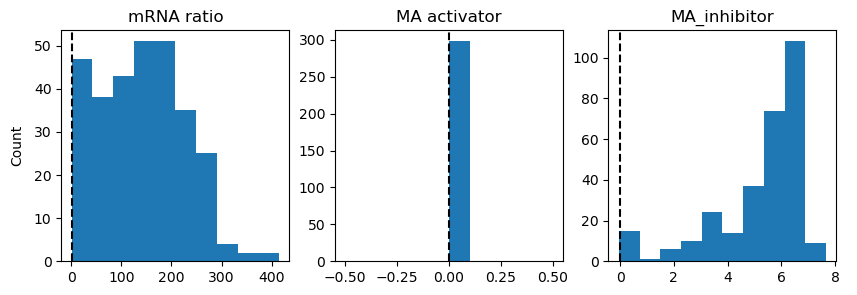

In [14]:
show_figure(ret_figs[0])

In [15]:
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

In [16]:
# scale and normalize it
df = 2**log_tpm_df.loc[genes].T
normalized_df=(df-df.mean())/df.std()
normalized_df = normalized_df
normalized_df['avg_exp'] = normalized_df.mean(axis = 1)
normalized_df.sort_values(by = 'avg_exp')

,b1849,b2499,b0523,b2557,b0522,b4006,b2476,b4005,b2313,b2312,b2500,b1131,avg_exp
starve_series__t12_starve,-1.613438,-1.565303,-1.581455,-1.890606,-1.614582,-1.459745,-1.683681,-1.506534,-1.456982,-1.616253,-1.469315,-1.851299,-1.609099
starve_series__t11_starve,-1.615014,-1.563946,-1.581455,-1.890525,-1.613469,-1.452232,-1.680228,-1.494265,-1.466713,-1.620168,-1.472144,-1.846697,-1.608071
starve_series__t09_starve,-1.614964,-1.566451,-1.581455,-1.893577,-1.614928,-1.463893,-1.683181,-1.510617,-1.435633,-1.611349,-1.468787,-1.851866,-1.608058
starve_series__t10_starve,-1.614505,-1.564182,-1.580510,-1.891288,-1.614249,-1.459283,-1.683465,-1.495615,-1.442500,-1.620016,-1.468289,-1.851343,-1.607104
starve_series__t08_starve,-1.612969,-1.566948,-1.581455,-1.890574,-1.614764,-1.461249,-1.680134,-1.501317,-1.425902,-1.609681,-1.477786,-1.852104,-1.606240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
rpoB__rpoBE672K_glc__1,1.557017,2.354855,2.379923,2.209466,2.466468,2.154967,1.754832,2.087677,0.946589,1.754172,1.428559,1.309323,1.866987
rpoB__rpoBE672K_glc__2,1.401730,2.445134,2.349443,2.350803,2.479193,2.159365,1.870230,2.044073,1.015726,1.773349,1.578830,1.289486,1.896447
ica__bw_delpurR_cytd__1,3.223046,1.772923,1.580077,1.465956,1.578927,4.279305,0.650507,5.132642,2.874797,2.656359,1.299322,0.525254,2.253259
glu__glu_ale6__1,2.244276,2.252475,2.736244,2.084635,1.968836,3.317855,0.678923,3.078972,1.176752,2.962788,2.199638,2.451666,2.262755
